<a href="https://colab.research.google.com/github/nehagoyal1994/cs480student/blob/main/06/Goyal_CS480_Assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

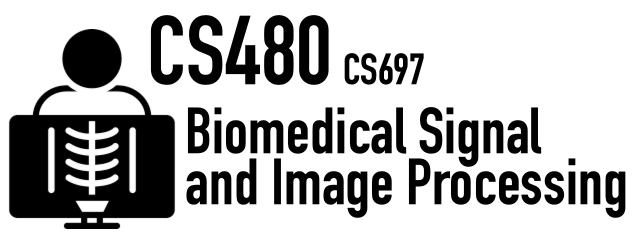
#Assignment 6

In [ ]:
# In this assignment, we will train a U-Net classifer to detect mitochondria
# in electron microscopy images!

In [ ]:
### IMPORTANT ###
#
# Activate GPU support: Runtime -> Change Runtime Type
# Hardware Accelerator: GPU
#
### IMPORTANT ###

In [33]:
# load numpy and matplotlib
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [34]:
# load the unet tensorflow code
!pip install git+https://github.com/jakeret/unet.git

  Cloning https://github.com/jakeret/unet.git to /tmp/pip-req-build-bjjlb8vg
  Running command git clone -q https://github.com/jakeret/unet.git /tmp/pip-req-build-bjjlb8vg
  Created wheel for unet: filename=unet-0.0.post0.dev81+gf557a51-py2.py3-none-any.whl size=25658 sha256=4e1d16b6475db36a6ba6363604e5e85d48e84f5f92015bdcf78e6675f099050e
  Stored in directory: /tmp/pip-ephem-wheel-cache-h86mgu4a/wheels/f5/38/c8/8f0a157cfd7616cc1a24811a52b9a669c0ee8fccc9f99d3cbc
Successfully built unet


In [35]:
# .. and use it!
# Note: There are a ton of U-Net implementations but this one is easier to use!
import unet

**Task 1**: Study the unet circle example and learn about mitochondria! [15 Points]

In [36]:
# The unet package allows to train a U-Net classifier with little code.
# As discussed in class, the U-Net can be used to label/segment/annotate images.

In [37]:
# TODO: Please study the Circles example 
# https://github.com/jakeret/unet/blob/master/notebooks/circles.ipynb

In [38]:
# TODO: ... and look how the (artificial) dataset is generated
# https://github.com/jakeret/unet/blob/master/src/unet/datasets/circles.py

In [39]:
# 1) Question
# TODO: Please describe what the U-Net is trained to do.
#


It was first used for biomedical image segmentation. Its architecture can be broadly thought of as an encoder network followed by a decoder network.

U-Net is trained to do image classification tasks, when we need not only to define the whole image by its class but also to segment areas of an image by class, i.e. produce a mask that will separate an image into several classes. The architecture consists of a contracting path to capture context and a symmetric expanding path that enables precise localization.

In [40]:
# 2) Question
# TODO: In circles.py, what does the following mean:
#     channels = 1
#     classes = 2
#


channels = the depth of the image, its grayscale image here and later in the code they tiled the image such that it has 3 channels (RGB)

classes = total number of categories or labels or classes (here output can be predicted as white or black  categories)

In [41]:
# 3) Question
# TODO: What are mitochondria and what is their appearance in
# electron microscopy data?
# Hint: You can validate your answer in Task 4!
#
# TODO: YOUR ANSWER

Mitochondria are membrane-bound cell organelles (mitochondrion, singular) that generate energy needed to power the cell's biochemical reactions.
Mitochondria are often represented bean-shaped organelles with two membranes and the inner membrane has folds which appear as tubular structures.


**Task 2**: Setup a datagenerator for mitochondria images! [45 Points]

In [42]:
# TODO: 
# Download https://cs480.org/data/mito.npz to your computer.
# Then, please upload mito.npz using the file panel on the left.

In [43]:
# The code below is similar to the circles.py file from Task 1.
# We follow Tensorflow conventions to design a tf.data.Dataset for training
# the U-Net.
#
# TODO: Please add four different data augmentation methods in the code block
# below. (image normalization to 0..1, horizontal data flip, vertical data flip,
# rotation by 90 degrees)
#
# Hint: https://github.com/jakeret/unet/blob/master/src/unet/datasets/oxford_iiit_pet.py#L25

In [45]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_datasets.core import DatasetInfo
from typing import Tuple, List

IMAGE_SIZE = (256, 256)
channels = 1
classes = 2

def load_data(count:int, splits:Tuple[float]=(0.7, 0.2, 0.1), **kwargs) -> List[tf.data.Dataset]:
    return [tf.data.Dataset.from_tensor_slices(_build_samples(int(split * count), **kwargs))
            for split in splits]


def _build_samples(sample_count:int, **kwargs) -> Tuple[np.array, np.array]:

    # here we load the mitochondria data
    loaded = np.load('mito.npz')
    loadedimages = loaded['arr_0'][0].copy()
    loadedmasks = loaded['arr_0'][1].copy()

    # now let's go to numpyland
    images = np.empty((sample_count, IMAGE_SIZE[0], IMAGE_SIZE[1], 1))
    labels = np.empty((sample_count, IMAGE_SIZE[0], IMAGE_SIZE[1], 2))
    for i in range(sample_count):
        image, mask = loadedimages[i], loadedmasks[i]

        image = image.reshape((IMAGE_SIZE[0], IMAGE_SIZE[1], 1)).astype(np.float)
        mask = mask.reshape((IMAGE_SIZE[0], IMAGE_SIZE[1], 1))

        #
        # TODO: Normalize the image to 0..1
        #
        image = tf.cast(image, tf.float32) / 255.0
        mask -= 1

        #
        # TODO: Use Tensorflow to flip the image horizontally
        #
        if tf.random.uniform(()) > 0.5:
          #
          image = tf.image.flip_left_right(image)
          mask = tf.image.flip_left_right(mask)
          #

        #
        # TODO: Use Tensorflow to flip the image vertically
        #
        if tf.random.uniform(()) > 0.5:
          #
          image = tf.image.flip_up_down(image)
          mask = tf.image.flip_up_down(mask)
          #

        #
        # TODO: Use Tensorflow to rotate the image 90 degrees
        #
        if tf.random.uniform(()) > 0.5:
          
          #
          image = tf.image.rot90(image)
          mask = tf.image.rot90(mask)
          #


        # augmentation done, let's store the image
        images[i] = image

        # here we split the mask to background and foreground
        fg = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 1), dtype=np.bool)
        fg[mask == 255] = 1
        bg = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 1), dtype=np.bool)
        bg[mask == 0] = 1
        
        labels[i, :, :, 0] = bg[:,:,0]
        labels[i, :, :, 1] = fg[:,:,0]

    return images, labels

**Task 3**: Let's train the U-Net! [25 Points]

In [46]:
#
# We can now create our training, validation, and testing data by calling
# our methods from Task 2.
#
train, val, test = load_data( 660, splits=(0.7, 0.2, 0.1) )

In [47]:
# 1) Question
# TODO: We have in total 660 images + 660 masks. Based on the code above,
# how many images are used for training alone?
#
# 

70% of total data available is used in training.
This means 0.7 x 660 = 462 images in training

In [48]:
#
# Let's setup the U-Net!
#
LEARNING_RATE = 1e-3

unet_model = unet.build_model(channels=channels,
                              num_classes=classes,
                              layer_depth=5,
                              filters_root=64,
                              padding="same")

unet.finalize_model(unet_model, learning_rate=LEARNING_RATE)

In [49]:
#
# And, let's setup the trainer...
#
trainer = unet.Trainer(checkpoint_callback=False,
                       learning_rate_scheduler=unet.SchedulerType.WARMUP_LINEAR_DECAY,
                       warmup_proportion=0.1,
                       learning_rate=LEARNING_RATE)

In [50]:
#
# ...and train the U-Net for 50 epochs with a batch_size of 10!
#
# TODO: Please complete the code below.
# Hint: Don't forget to use training and validation data.
# Hint 2: This will take roughly 30 minutes!
#
trainer.fit(unet_model,            
            train,
            val,
            epochs = 50,
            batch_size =10            
            )

Epoch 1/50
47/47 [==============================] - 44s 880ms/step - loss: 0.6092 - categorical_crossentropy: 0.6092 - categorical_accuracy: 0.2684 - mean_iou: 0.2491 - dice_coefficient: 0.5000 - auc_2: 0.5153 - val_loss: 0.2706 - val_categorical_crossentropy: 0.2706 - val_categorical_accuracy: 0.9434 - val_mean_iou: 0.3595 - val_dice_coefficient: 0.7286 - val_auc_2: 0.9936
Epoch 2/50
47/47 [==============================] - 40s 845ms/step - loss: 0.0926 - categorical_crossentropy: 0.0926 - categorical_accuracy: 0.9209 - mean_iou: 0.4229 - dice_coefficient: 0.8718 - auc_2: 0.9707 - val_loss: 0.3577 - val_categorical_crossentropy: 0.3577 - val_categorical_accuracy: 0.9434 - val_mean_iou: 0.3290 - val_dice_coefficient: 0.6641 - val_auc_2: 0.9938
Epoch 3/50
47/47 [==============================] - 40s 844ms/step - loss: 0.1035 - categorical_crossentropy: 0.1035 - categorical_accuracy: 0.9210 - mean_iou: 0.4188 - dice_coefficient: 0.8611 - auc_2: 0.9751 - val_loss: 0.1670 - val_categorical

**Task 4**: Let's predict mitochondria in the testing data! [15 Points]

In [51]:
# 
# After training, let's try the U-Net on our testing data.
#
# The code below displays the first 10 input images, the original masks by experts, 
# and the predicted masks from the U-Net.

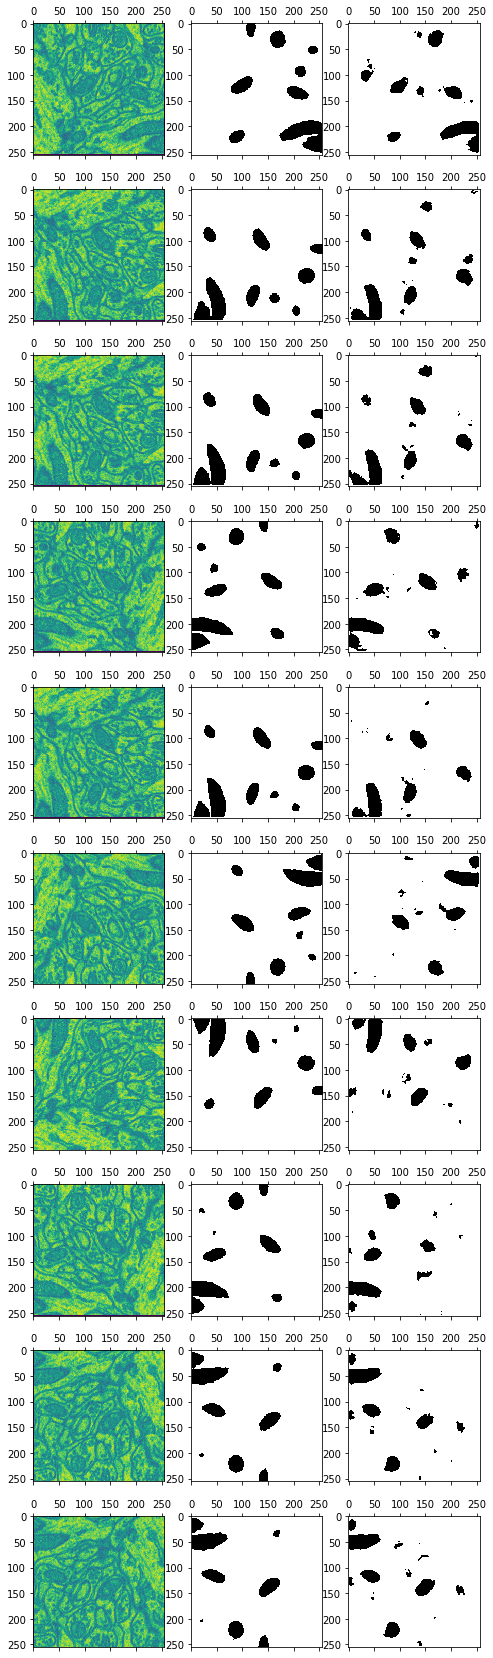

In [65]:
rows = 10
fig, axs = plt.subplots(rows, 3, figsize=(8, 30))
for ax, (image, label) in zip(axs, test.take(rows).batch(1)):
  
  prediction = unet_model.predict(image)
  
  ax[0].matshow(image[0, :, :, 0])
  ax[1].matshow(label[0, :, :, 1], cmap="gray")
  ax[2].matshow(prediction[0].argmax(axis=-1), cmap="gray")

In [25]:
# 1) Question
# TODO: Why do we use the prediction[0].argmax(axis=-1) command
# to display the prediction?
# 
# TODO: YOUR ANSWER


prediction.argmax raised an error for the input shape.

prediction[0] takes the correct shape (1, 256, 256, 2)

Argmax is used for finding the index of an array that results in the largest value. By adding the axis argument, numpy looks at the rows and columns individually.

Argmax is common for multi-class classification models to predict a vector of probabilities (or probability-like values), with one probability for each class label. The probabilities represent the likelihood that a sample belongs to each of the class labels.

The predicted probabilities are ordered such that the predicted probability at index 0 belongs to the first class, the predicted probability at index 1 belongs to the second class, and so on.

We can then map this integer value back to a class label

In [ ]:
# 2) Question
# TODO: Is the quality of the segmentation good and how could we improve it?
# Hint: Think along the lines of some traditional image processing rather than
# increasing the training data size.
#
# TODO: YOUR ANSWER

Yes, I think the quality is good with size of training data provided. We can improve the segmentation quality by changing the learning rate, epoches, batch size or the network structure by decreasing the number of convolutional layers.
We  can also use training set augmentation quite heavily - rotations, scaling and mirroring - and this may improved classification accuracy.


**Bonus**: Compare against the state-of-the-art literature! [33 Points]

In [15]:
#
# The following paper also uses a 2D U-Net to detect mitochondria:
# 
# https://danielhaehn.com/papers/?casser2020fast
#

In [16]:
# 1) Question
#
# TODO: How many learnable parameters does your trained unet_model have?
# Hint: You can use TF's Model Summary function to answer this.
#

In [66]:
unet_model.summary()

Model: "unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv_block_18 (ConvBlock)       (None, None, None, 6 37568       inputs[0][0]                     
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, None, None, 6 0           conv_block_18[0][0]              
__________________________________________________________________________________________________
conv_block_19 (ConvBlock)       (None, None, None, 1 221440      max_pooling2d_8[0][0]            
_______________________________________________________________________________________________

 31,030,658 parameters

In [ ]:
# 2) Question
#
# TODO: How many parameters do Casser et al. use?
#

1,958,533 parameters

In [ ]:
# 3) Question
#
# TODO: How did Casser et al. reduce the parameters?
#

They reduced the number of convolutional filters throughout the network. And then replace transpose convolutions in the decoder with light-weight bilinear upsampling layers that require no parameters.

In [ ]:
# 4) Question
#
# TODO: Why did Casser et al. reduce the parameters?
#

The 33.53% of the filters in the original U-Net stay inactive and waste significant compute. In contrast, reducing the parameters and replacing center-cropping from the original U-Net with padding resulted Casser et al. to have an optimized U-Net reaching to 99.7% utilization of CNN filters.

In [ ]:
#
# You made it!!
#
#                 _ ___                /^^\ /^\  /^^\_
#     _          _@)@) \            ,,/ '` ~ `'~~ ', `\.
#   _/o\_ _ _ _/~`.`...'~\        ./~~..,'`','',.,' '  ~:
#  / `,'.~,~.~  .   , . , ~|,   ,/ .,' , ,. .. ,,.   `,  ~\_
# ( ' _' _ '_` _  '  .    , `\_/ .' ..' '  `  `   `..  `,   \_
#  ~V~ V~ V~ V~ ~\ `   ' .  '    , ' .,.,''`.,.''`.,.``. ',   \_
#   _/\ /\ /\ /\_/, . ' ,   `_/~\_ .' .,. ,, , _/~\_ `. `. '.,  \_
#  < ~ ~ '~`'~'`, .,  .   `_: ::: \_ '      `_/ ::: \_ `.,' . ',  \_
#   \ ' `_  '`_    _    ',/ _::_::_ \ _    _/ _::_::_ \   `.,'.,`., \-,-,-,_,_,
#    `'~~ `'~~ `'~~ `'~~  \(_)(_)(_)/  `~~' \(_)(_)(_)/ ~'`\_.._,._,'_;_;_;_;_;
#